<a href="https://colab.research.google.com/github/FatmaBuseBorlu/Dramer-Dataset-LSTM/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython import get_ipython
from IPython.display import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split,TensorDataset
from torcheeg.datasets import DREAMERDataset
from torcheeg import transforms
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import kagglehub,os,kagglehub,random,shutil
from torcheeg.transforms import ToTensor, BaselineRemoval, MeanStdNormalize, To2d, RandomNoise
from imblearn.over_sampling import SMOTE

In [ ]:
# Kaggle'dan veri setini indirin
path = kagglehub.dataset_download("phhasian0710/dreamer")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/phhasian0710/dreamer/versions/1


In [ ]:
import os

# Veri seti yolunu kontrol edin
dataset_dir = "/root/.cache/kagglehub/datasets/phhasian0710/dreamer/versions/1"
mat_file_path = os.path.join(dataset_dir, "DREAMER.mat")

if os.path.exists(mat_file_path):
    print("DREAMER.mat dosyası bulundu!")
else:
    print("DREAMER.mat dosyası bulunamadı! Lütfen dosyanın doğru bir şekilde indirildiğinden emin olun.")


DREAMER.mat dosyası bulundu!


In [ ]:
from torcheeg.transforms import BandPass

In [ ]:
dataset = DREAMERDataset(
    mat_path='/root/.cache/kagglehub/datasets/phhasian0710/dreamer/versions/1/DREAMER.mat',
    io_path='./dreamer_rnn_data_safe1',
  offline_transform = transforms.Compose([
    transforms.BaselineRemoval(),
    transforms.MeanStdNormalize(),
    transforms.To2d(),
    transforms.ToTensor(),
    BandPass(low_cut_hz=0.5, high_cut_hz=50, sampling_rate=128),  # Yeni ekleme
    transforms.RandomNoise(std=0.02),
    transforms.RandomShift(max_shift=5),
    transforms.RandomFlip(axis=2)
]),
    online_transform=None, # No online transformation
    label_transform=transforms.Compose([
        transforms.Select('valence'),
        transforms.Binary(3.0)
    ]),
    chunk_size=128,
    baseline_chunk_size=128,
    num_baseline=61,
    num_worker=8
)

[2024-12-21 20:32:16] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ./dreamer_rnn_data_safe1.
INFO:torcheeg:🔍 | Detected cached processing results, reading cache from ./dreamer_rnn_data_safe1.


In [ ]:
# Veri Loader için SMOTE ile Dengeleme
data_loader = DataLoader(dataset, batch_size=len(dataset))
inputs, labels = next(iter(data_loader))

# Reshape the inputs to 2D: (samples, features)
inputs = inputs.numpy().reshape(inputs.shape[0], -1)  # Flatten the last 3 dimensions

smote = SMOTE()
inputs_resampled, labels_resampled = smote.fit_resample(inputs, labels)

balanced_dataset = TensorDataset(torch.tensor(inputs_resampled, dtype=torch.float32),
                                 torch.tensor(labels_resampled, dtype=torch.long))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
train_size = int(0.8 * len(balanced_dataset))
test_size = len(balanced_dataset) - train_size
train_dataset, test_dataset = random_split(balanced_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_size=128, hidden_size=128, num_layers=2, num_classes=2):
        super(BiLSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_size * 2, 1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # Reshape to [batch_size, seq_len, input_size]
        x = x.reshape(x.size(0), -1, self.hidden_size)
        # Remove the unsqueeze operation, it's not needed
        # x = x.unsqueeze(1)

        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.bilstm(x, (h0, c0))
        attention_weights = torch.softmax(self.attention(out), dim=1)
        out = torch.sum(attention_weights * out, dim=1)
        out = self.fc(self.dropout(out))
        return out

In [ ]:
# Model, Optimizasyon ve Kayıp Fonksiyonu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMWithAttention().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

In [ ]:
# Eğitim ve Test Fonksiyonları
def train_one_epoch():
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

In [ ]:
# Test Fonksiyonu
def test_model():
    model.eval()
    running_loss, all_preds, all_labels = 0.0, [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy, all_labels, all_preds

In [ ]:
# Eğitim Döngüsü
epochs, patience = 20, 3
best_loss, counter = float('inf'), 0
train_losses, test_losses, test_accs = [], [], []

for epoch in range(epochs):
    train_loss = train_one_epoch()
    test_loss, test_acc, _, _ = test_model()
    scheduler.step()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    if test_loss < best_loss:
        best_loss, counter = test_loss, 0
        print("En iyi model kaydedildi!")
    else:
        counter += 1
    if counter >= patience:
        print("Early stopping tetiklendi!")
        break

Epoch 1: Train Loss: 0.6780, Test Loss: 0.6588, Test Acc: 0.5945
En iyi model kaydedildi!
Epoch 2: Train Loss: 0.6373, Test Loss: 0.6205, Test Acc: 0.6315
En iyi model kaydedildi!
Epoch 3: Train Loss: 0.6019, Test Loss: 0.6264, Test Acc: 0.6304
Epoch 4: Train Loss: 0.5706, Test Loss: 0.5921, Test Acc: 0.6643
En iyi model kaydedildi!
Epoch 5: Train Loss: 0.5456, Test Loss: 0.5906, Test Acc: 0.6729
En iyi model kaydedildi!
Epoch 6: Train Loss: 0.5660, Test Loss: 0.5825, Test Acc: 0.6752
En iyi model kaydedildi!
Epoch 7: Train Loss: 0.5419, Test Loss: 0.5775, Test Acc: 0.6798
En iyi model kaydedildi!
Epoch 8: Train Loss: 0.5033, Test Loss: 0.5798, Test Acc: 0.6912
Epoch 9: Train Loss: 0.4621, Test Loss: 0.5780, Test Acc: 0.6999
Epoch 10: Train Loss: 0.4279, Test Loss: 0.5797, Test Acc: 0.7078
Early stopping tetiklendi!


In [ ]:
# Sonuçları tekrar test edip raporla
test_loss, test_acc, all_labels, all_preds = test_model()
print(f"Final Test Accuracy: {test_acc:.4f}")
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(all_labels, all_preds))

Final Test Accuracy: 0.6793
Confusion Matrix:
 [[3019 3676]
 [1824 8630]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.45      0.52      6695
           1       0.70      0.83      0.76     10454

    accuracy                           0.68     17149
   macro avg       0.66      0.64      0.64     17149
weighted avg       0.67      0.68      0.67     17149



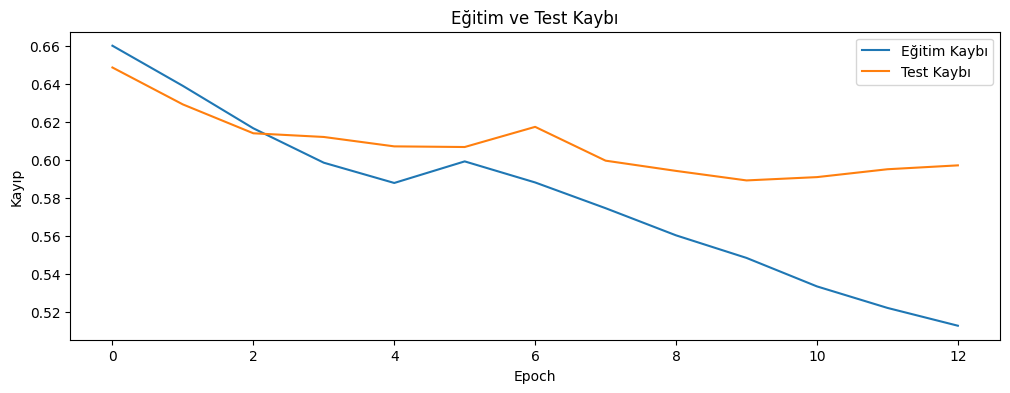

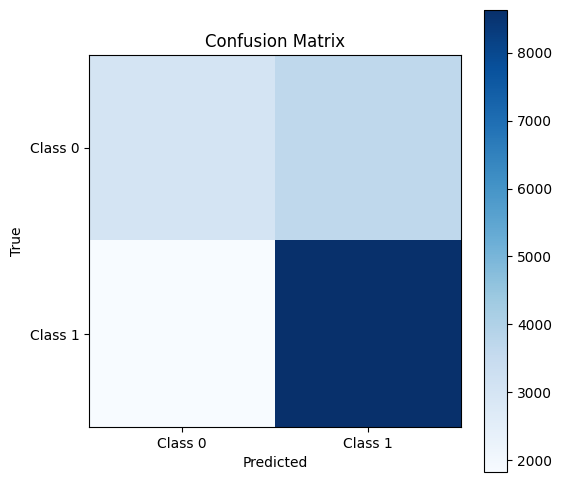

In [ ]:
def plot_results(labels, preds, train_losses, test_losses):
    # Basitleştirilmiş grafik fonksiyonu
    plt.figure(figsize=(12, 4))
    plt.plot(train_losses, label='Eğitim Kaybı')
    plt.plot(test_losses, label='Test Kaybı')
    plt.title('Eğitim ve Test Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()
    plt.show()

    plt.figure(figsize=(6, 6))
    cm = confusion_matrix(labels, preds)
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1], ['Class 0', 'Class 1'])
    plt.yticks([0, 1], ['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_results(all_labels, all_preds, train_losses, test_losses)